<a href="https://colab.research.google.com/github/harshavardhangadila/Training-Neural-networks-with-Keras/blob/main/Part%201/J_KerasCV_Data_Augmentation_(CutMix_MixUp_%2B_A_B_Comparison).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q keras-cv --upgrade


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 650.7/650.7 kB 16.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 34.8 MB/s eta 0:00:00


In [2]:
# Imports
import tensorflow as tf
import keras_cv
import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical

In [3]:
# Load Fashion MNIST dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

# Normalize images to [0, 1] and add channel dimension
x_train = x_train[..., tf.newaxis].astype("float32") / 255.0
x_test = x_test[..., tf.newaxis].astype("float32") / 255.0

# One-hot encode the labels
NUM_CLASSES = 10
y_train_cat = to_categorical(y_train, NUM_CLASSES)
y_test_cat = to_categorical(y_test, NUM_CLASSES)

print("Training set shape:", x_train.shape)
print("Testing set shape:", x_test.shape)


29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Training set shape: (60000, 28, 28, 1)
Testing set shape: (10000, 28, 28, 1)


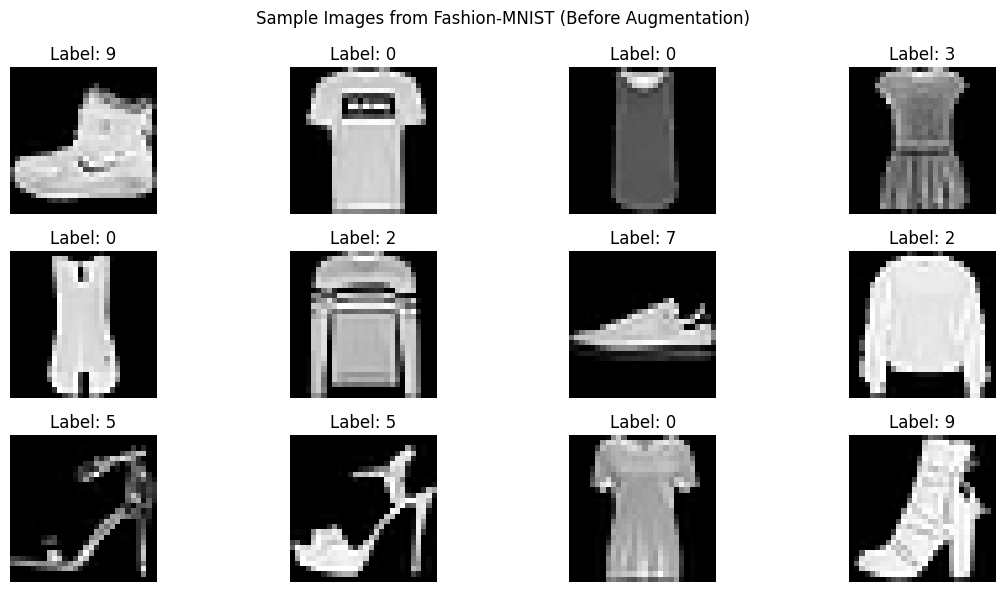

In [4]:
# Visualize some samples
plt.figure(figsize=(12, 6))
for i in range(12):
    plt.subplot(3, 4, i+1)
    plt.imshow(x_train[i].squeeze(), cmap='gray')
    plt.title(f"Label: {y_train[i]}")
    plt.axis('off')
plt.suptitle("Sample Images from Fashion-MNIST (Before Augmentation)")
plt.tight_layout()
plt.show()


In [5]:
# Parameters
BATCH_SIZE = 64
AUTOTUNE = tf.data.AUTOTUNE

# Normal dataset (no augmentation)
train_ds_normal = tf.data.Dataset.from_tensor_slices((x_train, y_train_cat))
train_ds_normal = train_ds_normal.shuffle(1024).batch(BATCH_SIZE).prefetch(AUTOTUNE)

# Apply CutMix augmentation
cutmix = keras_cv.layers.CutMix(alpha=1.0)
train_ds_cutmix = train_ds_normal.map(
    lambda x, y: cutmix({'images': tf.cast(x, tf.float32), 'labels': tf.cast(y, tf.float32)}),
    num_parallel_calls=AUTOTUNE
)
train_ds_cutmix = train_ds_cutmix.map(
    lambda d: (d['images'], d['labels']),
    num_parallel_calls=AUTOTUNE
)

# Apply MixUp augmentation
mixup = keras_cv.layers.MixUp(alpha=0.2)
train_ds_mixup = train_ds_normal.map(
    lambda x, y: mixup({'images': tf.cast(x, tf.float32), 'labels': tf.cast(y, tf.float32)}),
    num_parallel_calls=AUTOTUNE
)
train_ds_mixup = train_ds_mixup.map(
    lambda d: (d['images'], d['labels']),
    num_parallel_calls=AUTOTUNE
)


In [6]:
# Simple CNN Model for Comparison
def build_model():
    model = models.Sequential([
        layers.Flatten(input_shape=(28, 28, 1)),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(NUM_CLASSES, activation='softmax')
    ])

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model


In [7]:
# Build and train model on normal data
model_normal = build_model()

history_normal = model_normal.fit(
    train_ds_normal,
    validation_data=(x_test, y_test_cat),
    epochs=10,
    verbose=2
)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
938/938 - 15s - 16ms/step - accuracy: 0.7937 - loss: 0.5867 - val_accuracy: 0.8339 - val_loss: 0.4540
Epoch 2/10
938/938 - 7s - 8ms/step - accuracy: 0.8478 - loss: 0.4255 - val_accuracy: 0.8520 - val_loss: 0.4060
Epoch 3/10
938/938 - 5s - 6ms/step - accuracy: 0.8588 - loss: 0.3899 - val_accuracy: 0.8610 - val_loss: 0.3863
Epoch 4/10
938/938 - 4s - 5ms/step - accuracy: 0.8660 - loss: 0.3693 - val_accuracy: 0.8668 - val_loss: 0.3728
Epoch 5/10
938/938 - 4s - 4ms/step - accuracy: 0.8702 - loss: 0.3533 - val_accuracy: 0.8677 - val_loss: 0.3685
Epoch 6/10
938/938 - 3s - 3ms/step - accuracy: 0.8756 - loss: 0.3393 - val_accuracy: 0.8748 - val_loss: 0.3561
Epoch 7/10
938/938 - 3s - 3ms/step - accuracy: 0.8798 - loss: 0.3296 - val_accuracy: 0.8733 - val_loss: 0.3475
Epoch 8/10
938/938 - 5s - 5ms/step - accuracy: 0.8811 - loss: 0.3209 - val_accuracy: 0.8787 - val_loss: 0.3419
Epoch 9/10
938/938 - 3s - 3ms/step - accuracy: 0.8835 - loss: 0.3129 - val_accuracy: 0.8753 - val_loss: 0.3509

In [8]:
# Build and train model on CutMix-augmented data
model_cutmix = build_model()

history_cutmix = model_cutmix.fit(
    train_ds_cutmix,
    validation_data=(x_test, y_test_cat),
    epochs=10,
    verbose=2
)


Epoch 1/10
938/938 - 6s - 7ms/step - accuracy: 0.5356 - loss: 1.5222 - val_accuracy: 0.7986 - val_loss: 0.6788
Epoch 2/10
938/938 - 8s - 8ms/step - accuracy: 0.5697 - loss: 1.4122 - val_accuracy: 0.8230 - val_loss: 0.6033
Epoch 3/10
938/938 - 3s - 3ms/step - accuracy: 0.5838 - loss: 1.3702 - val_accuracy: 0.8271 - val_loss: 0.5708
Epoch 4/10
938/938 - 3s - 3ms/step - accuracy: 0.5877 - loss: 1.3595 - val_accuracy: 0.8260 - val_loss: 0.5936
Epoch 5/10
938/938 - 4s - 4ms/step - accuracy: 0.5928 - loss: 1.3454 - val_accuracy: 0.8260 - val_loss: 0.5677
Epoch 6/10
938/938 - 4s - 5ms/step - accuracy: 0.5950 - loss: 1.3320 - val_accuracy: 0.8342 - val_loss: 0.5499
Epoch 7/10
938/938 - 3s - 3ms/step - accuracy: 0.6005 - loss: 1.3244 - val_accuracy: 0.8401 - val_loss: 0.5329
Epoch 8/10
938/938 - 6s - 6ms/step - accuracy: 0.6024 - loss: 1.3226 - val_accuracy: 0.8410 - val_loss: 0.5318
Epoch 9/10
938/938 - 4s - 5ms/step - accuracy: 0.6002 - loss: 1.3184 - val_accuracy: 0.8430 - val_loss: 0.5303
E

In [9]:
# Build and train model on MixUp-augmented data
model_mixup = build_model()

history_mixup = model_mixup.fit(
    train_ds_mixup,
    validation_data=(x_test, y_test_cat),
    epochs=10,
    verbose=2
)


Epoch 1/10
938/938 - 7s - 7ms/step - accuracy: 0.7612 - loss: 0.8959 - val_accuracy: 0.8381 - val_loss: 0.4715
Epoch 2/10
938/938 - 3s - 3ms/step - accuracy: 0.8094 - loss: 0.7604 - val_accuracy: 0.8498 - val_loss: 0.4313
Epoch 3/10
938/938 - 3s - 3ms/step - accuracy: 0.8173 - loss: 0.7246 - val_accuracy: 0.8554 - val_loss: 0.4139
Epoch 4/10
938/938 - 5s - 5ms/step - accuracy: 0.8228 - loss: 0.7066 - val_accuracy: 0.8628 - val_loss: 0.3884
Epoch 5/10
938/938 - 6s - 6ms/step - accuracy: 0.8276 - loss: 0.6893 - val_accuracy: 0.8616 - val_loss: 0.3887
Epoch 6/10
938/938 - 5s - 5ms/step - accuracy: 0.8305 - loss: 0.6780 - val_accuracy: 0.8646 - val_loss: 0.3838
Epoch 7/10
938/938 - 5s - 5ms/step - accuracy: 0.8324 - loss: 0.6727 - val_accuracy: 0.8679 - val_loss: 0.3750
Epoch 8/10
938/938 - 3s - 3ms/step - accuracy: 0.8364 - loss: 0.6594 - val_accuracy: 0.8687 - val_loss: 0.3706
Epoch 9/10
938/938 - 5s - 5ms/step - accuracy: 0.8393 - loss: 0.6504 - val_accuracy: 0.8749 - val_loss: 0.3648
E

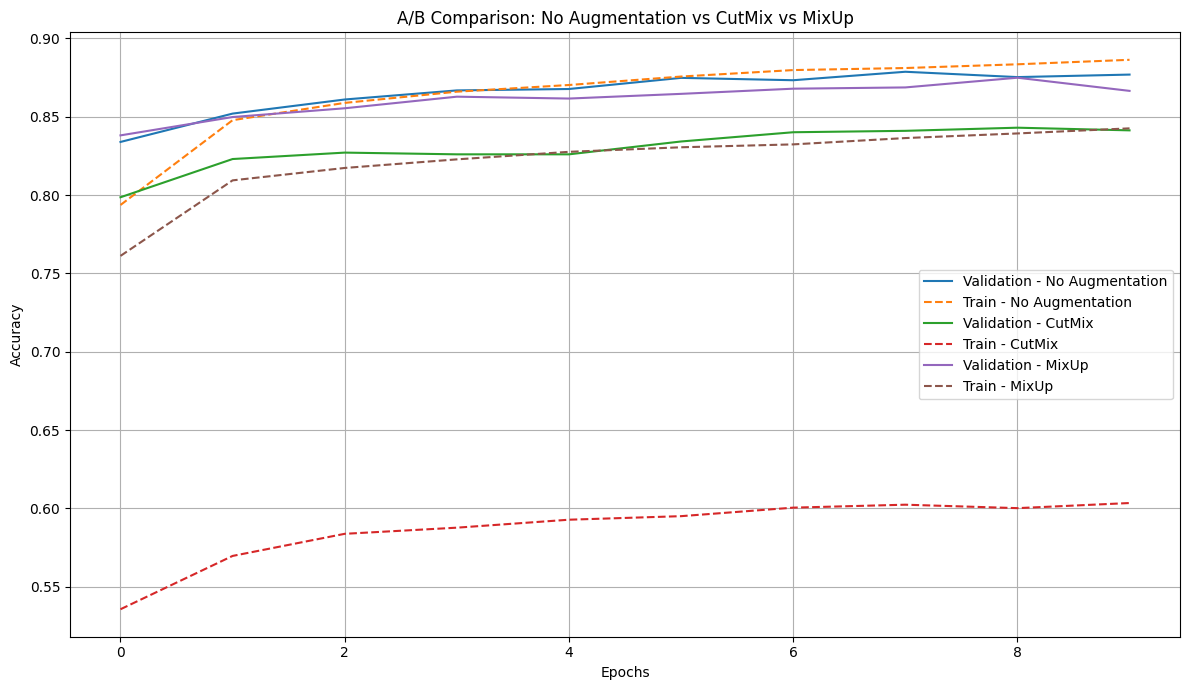

In [10]:
# Plot all models side by side
plt.figure(figsize=(12, 7))

# Normal
plt.plot(history_normal.history['val_accuracy'], label='Validation - No Augmentation')
plt.plot(history_normal.history['accuracy'], '--', label='Train - No Augmentation')

# CutMix
plt.plot(history_cutmix.history['val_accuracy'], label='Validation - CutMix')
plt.plot(history_cutmix.history['accuracy'], '--', label='Train - CutMix')

# MixUp
plt.plot(history_mixup.history['val_accuracy'], label='Validation - MixUp')
plt.plot(history_mixup.history['accuracy'], '--', label='Train - MixUp')

plt.title("A/B Comparison: No Augmentation vs CutMix vs MixUp")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [11]:
# Evaluate models
test_acc_normal = model_normal.evaluate(x_test, y_test_cat, verbose=0)[1]
test_acc_cutmix = model_cutmix.evaluate(x_test, y_test_cat, verbose=0)[1]
test_acc_mixup = model_mixup.evaluate(x_test, y_test_cat, verbose=0)[1]

print(f"Test Accuracy (No Augmentation): {test_acc_normal:.4f}")
print(f"Test Accuracy (CutMix Augmentation): {test_acc_cutmix:.4f}")
print(f"Test Accuracy (MixUp Augmentation): {test_acc_mixup:.4f}")


Test Accuracy (No Augmentation): 0.8769
Test Accuracy (CutMix Augmentation): 0.8413
Test Accuracy (MixUp Augmentation): 0.8665
